In [1]:
# O NLTK é um kit de ferramentas para trabalharmos com linguagem natural no Python
# Vamos utilizar apenas as definições de Stop Words do NLTK para removê-las da nossa word cloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython import display
import time

from pyspark.sql import SparkSession
from pyspark.sql import functions as f


spark = SparkSession.builder\
    .master('local[*]') \
    .config('spark.driver.host', '127.0.0.1')\
    .appName('WordCloud')\
    .getOrCreate()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raphaeloliveira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/22 20:08:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/22 20:08:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
# def trata_tweets(df):
#     words = df \
#         .select(f.explode(f.split(f.lower('_c0'), " ")) \                     # Adicionei a função lower para colocar todo o texto em minúsculo O "_c0" é o nome da coluna do DataFrame que contém os dados
#         .alias("word")) \
#         .withColumn('word', f.regexp_replace('word', r'http\S+', '')) \       # Retira os endereço web. O HTTP está em maiúsculo por conta da função upper utilizada acima
#         .withColumn('word', f.regexp_replace('word', r'@\w+', '')) \          # Remove os nomes dos usuário do Twitter (@nome_usuário)
#         .withColumn('word', f.regexp_replace('word', 'rt', '')) \             # Remove a marcação RT dos retweets
#         .na.replace('', None) \                                               # Transforma vazios em None
#         .na.drop()                                                            # Retira os valor nulos
#     return words

In [2]:
def trata_tweets(df):
    words = df \
        .select(f.explode(f.split(f.lower('value'), " ")) \
        .alias("word")) \
        .withColumn('word', f.regexp_replace('word', r'http\S+', '')) \
        .withColumn('word', f.regexp_replace('word', r'@\w+', '')) \
        .withColumn('word', f.regexp_replace('word', 'rt', '')) \
        .na.replace('', None) \
        .na.drop()
    return words

[1] O método collect do Spark é uma action e neste ponto é bom dar destaque ao conceito de Lazy Evaluation do Spark. Em resumo, no Spark temos funções de transformação e ação. Quando utilizamos as transformations o Spark cria um plano de ação e não executa a tarefa imediatamente. Este plano de ação é executado apenas quando utilizamos uma action. Isso permite que o Spark gere um plano de execução otimizado, mesclando algumas transformações e até mesmo pulando algumas que sejam desnecessárias.

[2] Documentação do wordcloud: https://amueller.github.io/word_cloud/index.html

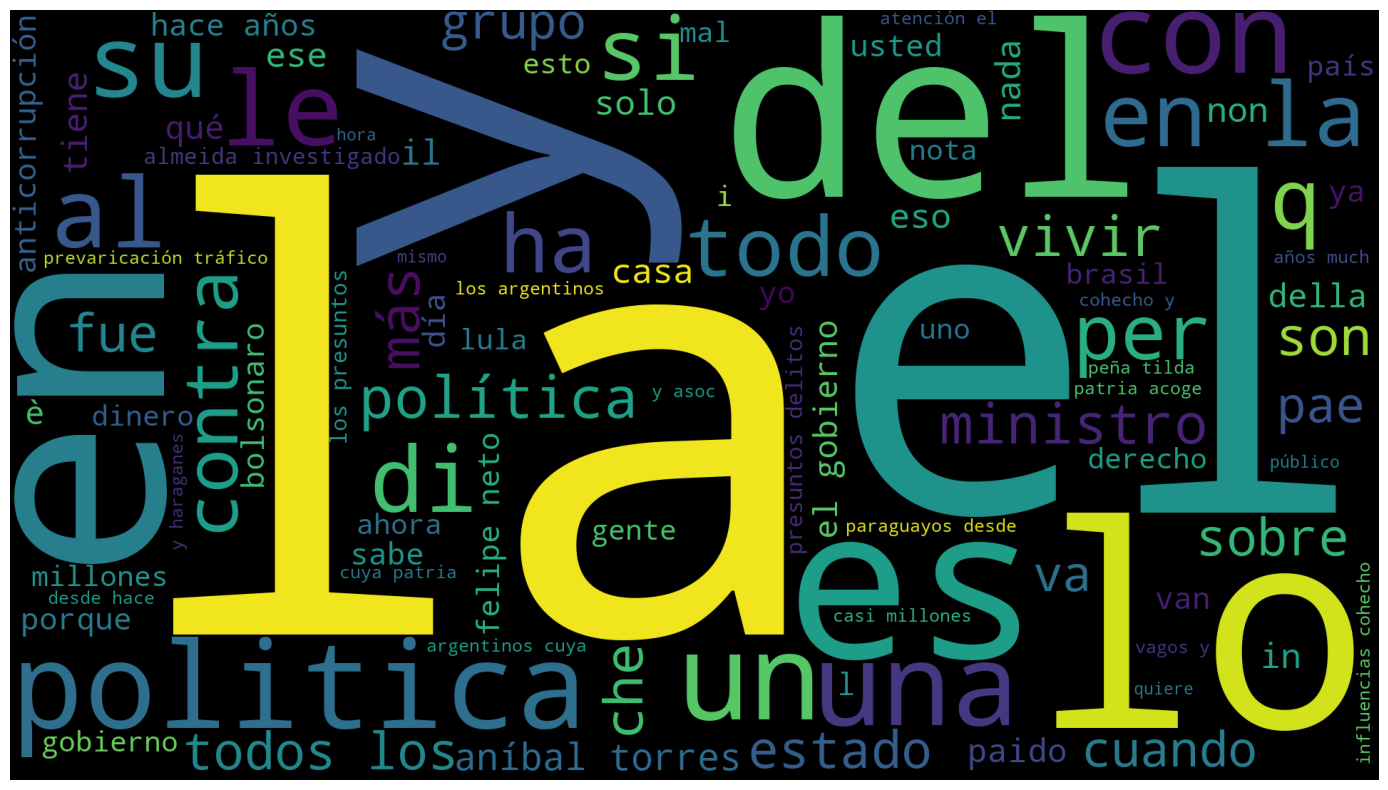

In [3]:
stops = stopwords.words('portuguese')                               # Criando uma variável com as Stop Word em português. Se for utilizar tweets em inglês basta modificar 'portuguese' para 'english'
stops.append('carnaval')                                             # Pode ser interessante retirar a palavra utilizada na pesquisa
plt.figure(figsize=(20, 10))                                        # Cria a figura e defini o tamanho dela (largura, altura)

path = '../datalake/twitter/parquet/'

while True:
    try:      # Este try/except foi colocado para tratar os erros que aparecem quando interrompemos o processo
        words = spark.read.parquet(path, encoding='utf-8')          # Lendo o conjunto de arquivos CSV na pasta /csv
        words = trata_tweets(words)                                 # Aplicando nossa função de tratamento
        rows = words.collect()                                      # Transformando o DataFrame em uma lista de linhas [1]
        all_words = ''
        for row in rows:
            all_words = all_words + ' ' + row['word']

        wordcloud = WordCloud(stopwords=stops,
                              background_color="black",
                              width=1920,
                              height=1080,
                              max_words=100
                              ).generate(all_words)                 # Word cloud simples. Mais detalhes em [2]

        plt.cla()                                                   # Limpa os eixos do gráfico
        plt.axis('off')                                             # Oculta as marcações dos eixos
        plt.imshow(wordcloud)                                       # Utilizado para exibir os dados como uma imagem
        display.display(plt.gcf())                                  # Mostrando a nossa word cloud no output do notebook
        display.clear_output(wait=True)                             # Limpa o output do notebook
        time.sleep(5)
    except KeyboardInterrupt:
        break